In [29]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date, timedelta

# Setting pandas dataframe display options
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)
pd.set_option("display.max_rows", 20)

# Set pandas style
plt.style.use('seaborn')

In [30]:
#### Functions ####
def compute_drawdowns(dataframe):
    """
    Function to compute drawdowns of a timeseries
    """
    return (dataframe / dataframe.cummax() -1) * 100

In [31]:
#### Main Script ####
Begin = "2014-12-31"
Yesterday = date.today() - timedelta(days = 1)
End   = Yesterday.strftime('%Y-%m-%d')

# MSid e Nomes dos fundos
MSid = ['F0GBR05ZUY', 'F00000V33P']
Nomes = ['MFSTR_A1', 'MFSTR_AH1']
fundos = pd.DataFrame()

# Conversão de datetime
conv = time.strptime(Begin,"%Y-%m-%d") 
start_date = time.strftime("%m/%d/%Y",conv)

# Download dos fundos e criação de dataframe geral
for ticker in MSid:
    url = "https://lt.morningstar.com/api/rest.svc/timeseries_price/okhysb8aoh?id=" + str(ticker) + "&currencyId=BAS&idtype=Morningstar&frequency=daily&startDate=" + start_date + "&outputType=CSV"
    fundo = pd.read_csv(url, sep = ";" , index_col = 'date', parse_dates = True)
    fundo =  fundo.drop('Unnamed: 2', 1)
    fundos = fundos.merge(fundo, left_index = True, right_index = True, how='outer')
    
fundos.columns = Nomes
fundos = fundos.fillna(method='ffill')

#### Returns ####
returns = (fundos / fundos.shift(1)) - 1

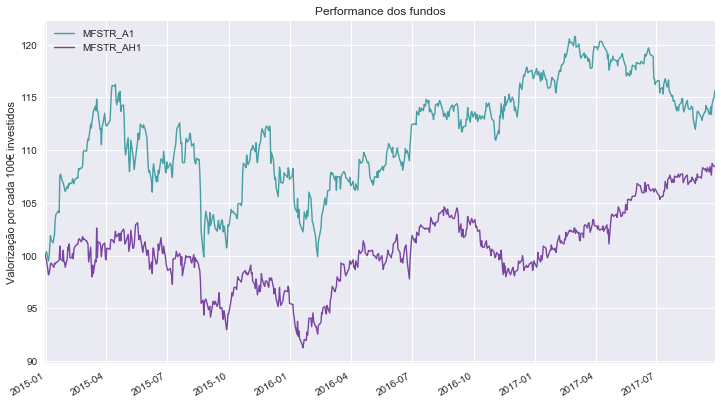

In [32]:
#### Normalization to 100 ####
fundos_norm = (fundos / fundos.iloc[0] * 100)

#### Plotting funds ####
fundos_norm.plot(figsize = (12, 7),  alpha = 0.7, lw = 1.4, color=['teal', 'indigo'])
plt.title('Performance dos fundos')
plt.ylabel('Valorização por cada 100€ investidos')
plt.xlabel('')
plt.show()

In [33]:
#### Computing Drawdowns ####
DD = compute_drawdowns(fundos_norm)

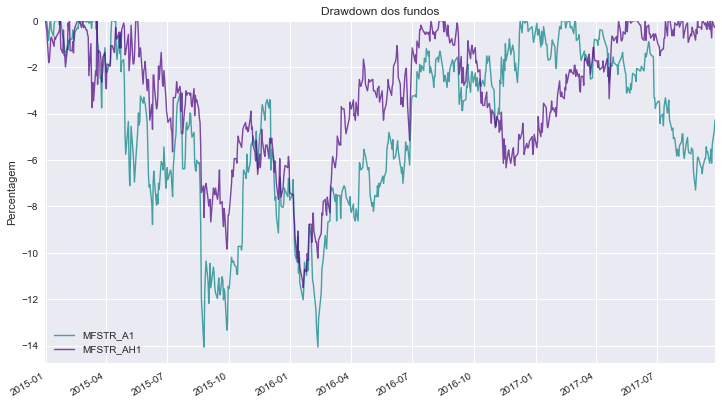

In [34]:
#### Plotting drawdowns ####
DD.plot(figsize = (12, 7),  alpha = 0.7, lw = 1.4, color=['teal', 'indigo'])
plt.title('Drawdown dos fundos')
plt.xlabel('')
plt.ylabel('Percentagem')
plt.ylim(ymax=0)
plt.show()

In [35]:
diferencial = ((fundos_norm['MFSTR_A1'] / fundos_norm['MFSTR_AH1']) - 1 )* 100

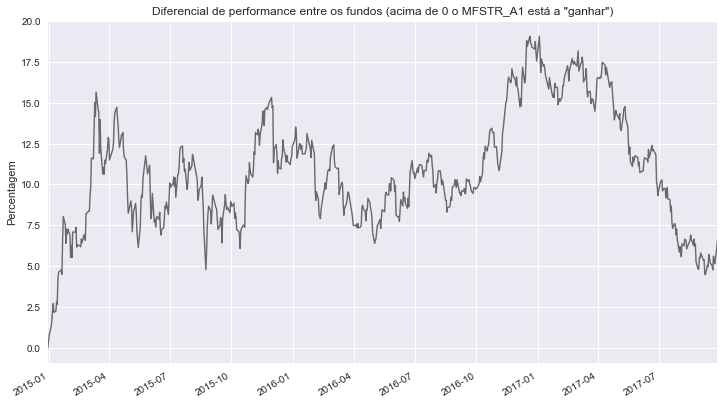

In [36]:
diferencial.plot(figsize = (12, 7), lw = 1.4, color='dimgray', alpha=1)
plt.title('Diferencial de performance entre os fundos (acima de 0 o MFSTR_A1 está a "ganhar")')
plt.ylabel('Percentagem')
plt.xlabel('')
plt.show()

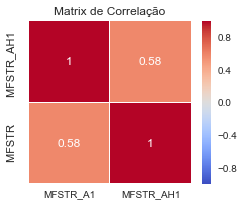

In [37]:
#### Correlation (bonus: Seaborn heatmap)####
Rcorr_matrix = returns.corr()
a = -0.5

# Normal heatmap
fig, ax = plt.subplots()
fig.set_size_inches(4, 3) # 68%
sns.heatmap(Rcorr_matrix, annot = True, cmap = "coolwarm", linewidths=.2, vmin=- 1,  square=True, yticklabels ='')
plt.title('Matrix de Correlação')
plt.ylabel('    MFSTR         MFSTR_AH1')
plt.show()

In [38]:
#### Desvios padrões ####
pd.DataFrame(returns.std()).transpose () * 1000

,MFSTR_A1,MFSTR_AH1
0,6.923187,6.427462


In [39]:
### weights ####
weights1 = np.array([0.5, 0.5])

### Calculate Portfolio value with linear algebra ####
fundos_norm["50/50"] = np.dot(fundos_norm, weights1) # weights1 * quotes

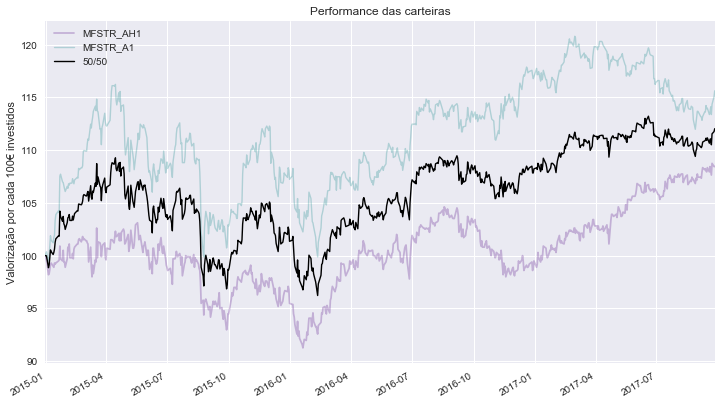

In [40]:
#### Plotting ####
fundos_norm["MFSTR_AH1"].plot(figsize = (12, 7), title = "Portfolio", c = 'indigo', alpha = 0.25)
fundos_norm['MFSTR_A1'].plot(figsize = (12, 7), color='teal', lw = 1.4, alpha = 0.25)
fundos_norm['50/50'].plot(figsize = (12, 7), color='black', lw = 1.4, label='50/50', alpha=1)
plt.legend(loc='upper left')
plt.title('Performance das carteiras')
plt.ylabel('Valorização por cada 100€ investidos')
plt.xlabel('')
plt.show()

In [41]:
#### Returns ####
returns = (fundos_norm / fundos_norm.shift(1)) - 1

In [42]:
#### Desvios padrões ####
pd.DataFrame(returns.std()).transpose () * 1000

,MFSTR_A1,MFSTR_AH1,50/50
0,6.923187,6.427462,5.954152


In [43]:
#### Computing Drawdowns ####
DD = compute_drawdowns(fundos_norm)

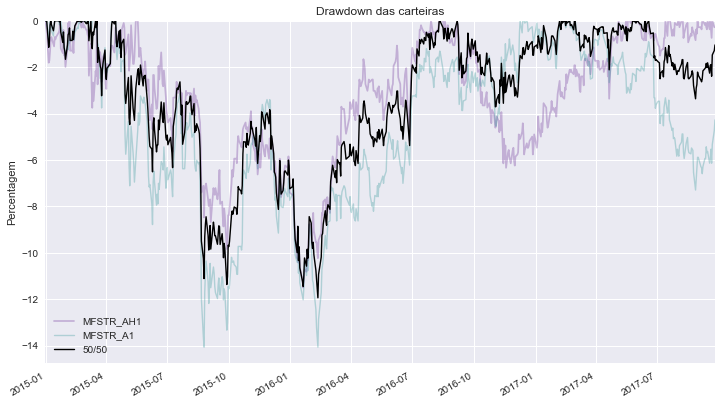

In [44]:
#### Plotting drawdowns ####
DD["MFSTR_AH1"].plot(figsize = (12, 7), title = "Portfolio", c = 'indigo', alpha = 0.25)
DD['MFSTR_A1'].plot(figsize = (12, 7), color='teal', lw = 1.4, alpha = 0.25)
DD['50/50'].plot(figsize = (12, 7), color='black', lw = 1.4, label='50/50', alpha=1)
plt.title('Drawdown das carteiras')
plt.xlabel('')
plt.ylabel('Percentagem')
plt.ylim(ymax=0)
plt.legend(loc='lower left')
plt.show()

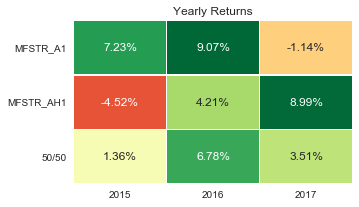

In [48]:
# Resampling to yearly (business year)
yearly_quotes = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes = pd.concat([fundos_norm.iloc[:1], yearly_quotes])

# Returns
yearly_returns = ((yearly_quotes / yearly_quotes.shift(1)) - 1) * 100
returns = yearly_returns.set_index([list(range(2013, 2018))]).drop([2013, 2014])

#### Inverter o sentido das rows no dataframe ####
returns = returns.transpose()

# Yearly returns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(5, 3) # 68%
heatmap = sns.heatmap(returns, annot=True, cmap="RdYlGn", linewidths=.2, fmt=".2f", cbar=False, center=1)
for t in heatmap.texts: t.set_text(t.get_text() + "%")
plt.title('Yearly Returns')
plt.yticks(rotation=360)
plt.show()